In [1]:
import sys
sys.path.append("../dataset/")

import datetime
import glob
import json
import matplotlib.pyplot as plt
import nrrd
import numpy as np
import os
import tensorflow as tf
from keras_unet_collection import losses

from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from dataset import UltraSoundImages
from keras_unet_collection import models
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img
# from utils import plot_history

In [2]:
import seaborn as sns

In [3]:
# Prepare data generator
# raw_dir = "../RawUSGimagesNRRD"
# raw_images = raw_dir + "/data_output"
# raw_masks = raw_dir + "/masks"

raw_dir = "../dataUSGthyroid/samsung_processed"
raw_images = raw_dir + "/images"
raw_masks = raw_dir + "/masks"

raw_images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))
raw_masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))

TEST_LEN = 10
VAL_LEN = 60
TRAIN_LEN = len(raw_images_paths) - VAL_LEN - TEST_LEN

batch_size = 8

train_images = raw_images_paths[:TRAIN_LEN]
validation_images = raw_images_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
test_images =  raw_images_paths[-TEST_LEN:]

train_masks = raw_masks_paths[:TRAIN_LEN]
validation_masks = raw_masks_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
test_masks =  raw_masks_paths[-TEST_LEN:]


size = (256, 256)
train_gen = UltraSoundImages(batch_size, train_images, train_masks, size=size)
val_gen = UltraSoundImages(batch_size, validation_images, validation_masks, size=size)
test_gen = UltraSoundImages(batch_size, test_images, test_masks, size=size)

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading


In [4]:
images, masks = val_gen.__getitem__(1)
image = images[1]
mask = masks[1]

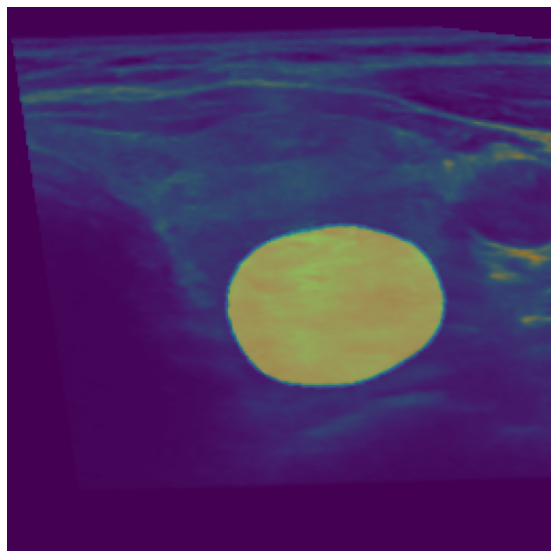

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.axis('off')
plt.show()

In [6]:
import tensorflow.keras.backend as K

def cutom_focal_tversky(y_true, y_pred, alpha=0.7, gamma=4/3):
    return losses.focal_tversky(y_true, y_pred, alpha=alpha, gamma=gamma)

custom_objects = {'cutom_focal_tversky': cutom_focal_tversky}

class ModelTester:
    
    def __init__(self, path_to_model, ds_gen):
        self.path_to_model = path_to_model
        self.custom_objects = {'cutom_focal_tversky': cutom_focal_tversky}
        self.base_path = f'output/{path_to_model}'
        self.model_path = f'{self.base_path}model/model'
        self.meta_path = f'{self.base_path}meta/'
        self.images, self.masks = ds_gen.__getitem__(1)
        self.history = json.load(open(self.meta_path+'history.json'))
        self.model = tf.keras.models.load_model(self.model_path, custom_objects=custom_objects)
        
        
    def create_report(self, model_summary=False, custom_objects=None):
        model_path = f'{self.base_path}model/model'
        meta_path = f'{self.base_path}meta/'
        history = json.load(open(self.meta_path+'history.json'))
        self.plot_history()
        
        # images, masks = val_gen.__getitem__(1)
        image = self.images[1]
        mask = self.masks[1]


        # output_masks = model.predict(np.expand_dims(images, 3))
        # cm = confusion_matrix(flat_truth, flat_preds(masks, output_masks))
        # print(cm)

        output_mask = self.model.predict(np.expand_dims(image, axis=[0,3]))[0]
        dice_value = self.dice_coef(mask, output_mask)
        print(f'dice coefficients {dice_value}')
        print(self.basic_metrics(mask, output_mask))
        
        TP, TN, FP, FN = self.calculate_segmentation_metrics(mask, output_mask)
        self.plot_confusion_matrix(TP, TN, FP, FN)

        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5)
        plt.axis('off')
        plt.show()
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.imshow(output_mask, alpha=0.5)
        plt.axis('off')
        plt.show()

        if model_summary:
            print(model.summary())
    
    
    def plot_history(self):
        # Extract the history values
        loss = self.history['loss']
        acc = self.history['accuracy']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_accuracy']

        # Plot the loss values
        plt.figure(figsize=(16, 8))
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Training', 'Validation'])
        plt.show()

        # Plot the accuracy values
        plt.figure(figsize=(16, 8))
        plt.plot(acc)
        plt.plot(val_acc)
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Training', 'Validation'])
        plt.show()
        
    def dice_coef(self, y_true, y_pred, smooth=100):        
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return dice
    
    
    def calculate_segmentation_metrics(self, y_true, y_pred):
        """
        Calculates TP, TN, FP, FN values for binary segmentation.
        """
        # Convert to numpy arrays of int type
        # y_true = np.array(y_true, dtype=int).flatten()
        # y_pred = np.array(y_pred, dtype=int).flatten()
    
        y_true = np.round(y_true).astype(int).flatten()
        y_pred = np.round(y_pred).astype(int).flatten()

        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        return TP, TN, FP, FN
    
    
    def basic_metrics(self, y_true, y_pred):
        TP, TN, FP, FN = self.calculate_segmentation_metrics(y_true, y_pred)
        
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        
        return precision, recall, f1
    

    def plot_confusion_matrix(self, TP, TN, FP, FN):
        cmat = [[TP, FN], [FP, TN]]
        plt.figure(figsize = (6,6))
        sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1, linewidth=2.)
        plt.xlabel("predictions")
        plt.ylabel("real values")
        plt.show()
    
        
    def make_prediction(self):
        image = self.images[1]
        mask = self.masks[1]
        output_mask = self.model.predict(np.expand_dims(image, axis=[0,3]))[0]
        

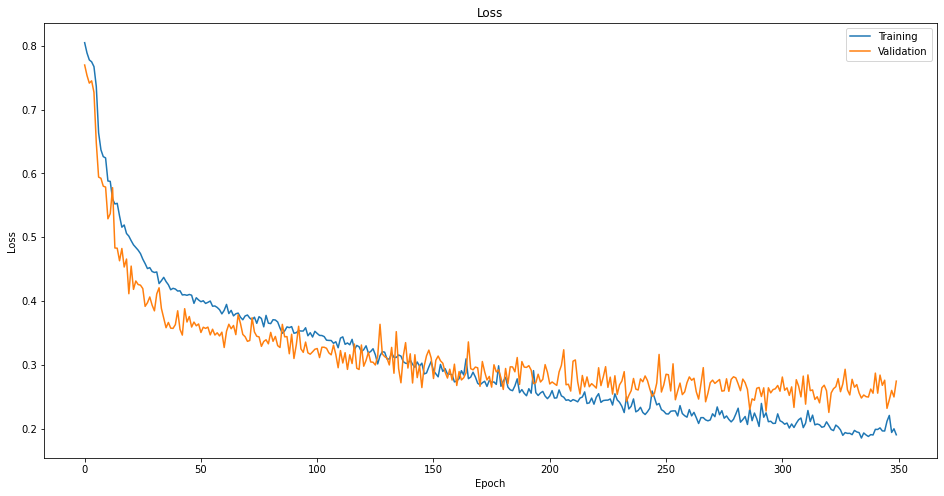

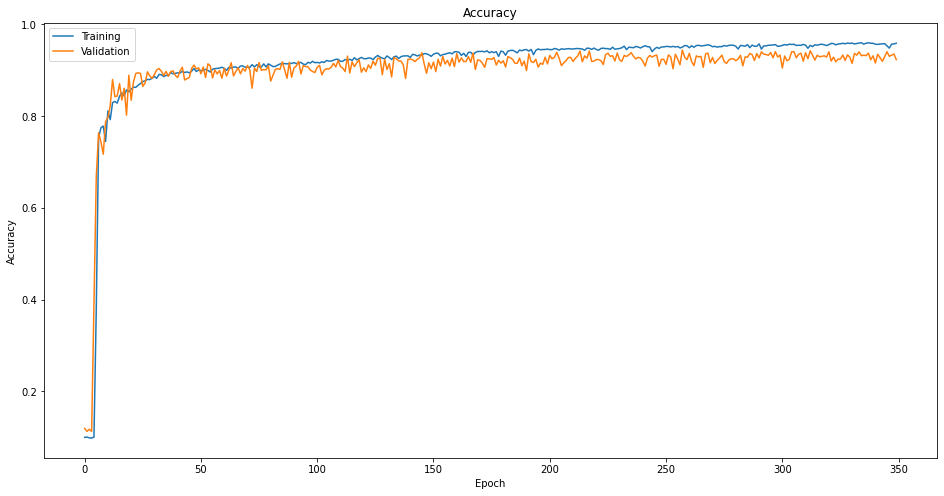

dice coefficients 0.81549072265625
(0.7002711756260966, 0.9753388135969785, 0.8152274837511606)


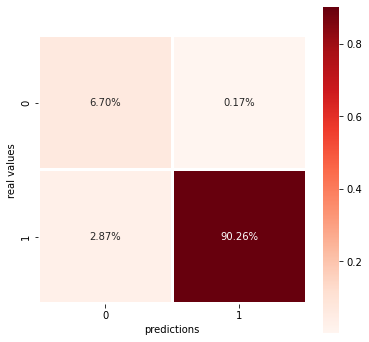

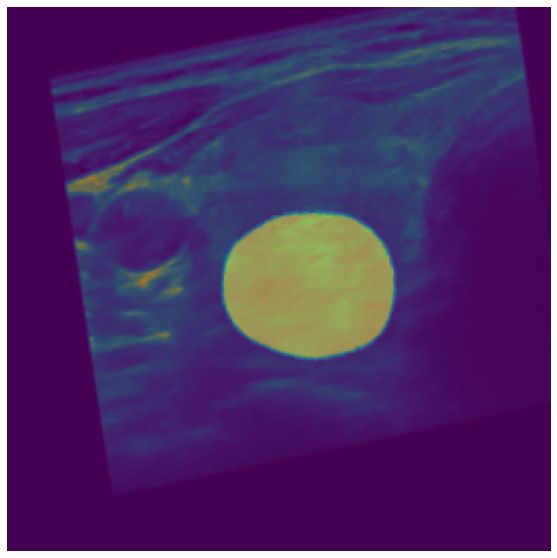

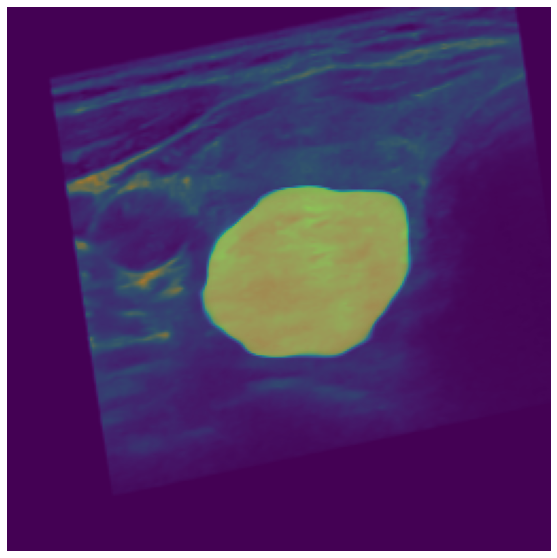

In [7]:
u2net_2d_tester = ModelTester('u2net_2d/old/2023-04-13-07-48-28/', val_gen)
u2net_2d_tester.create_report()

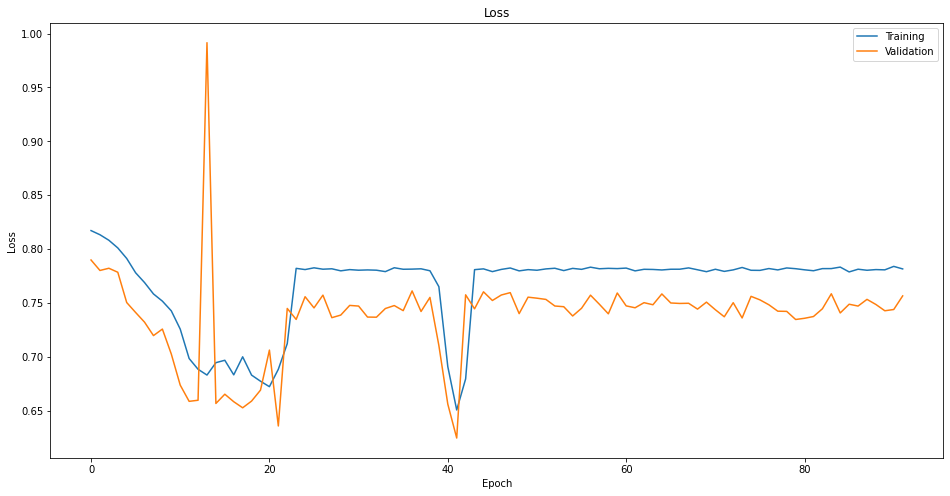

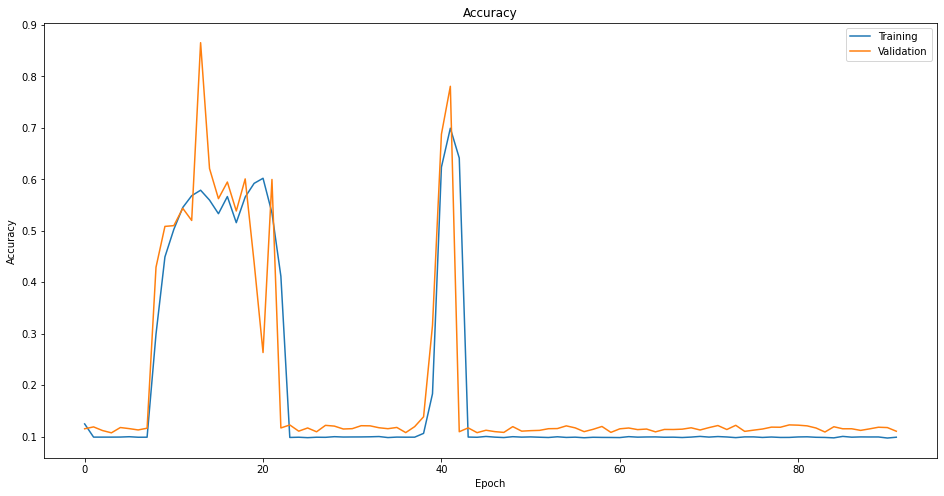

dice coefficients 0.2949737310409546


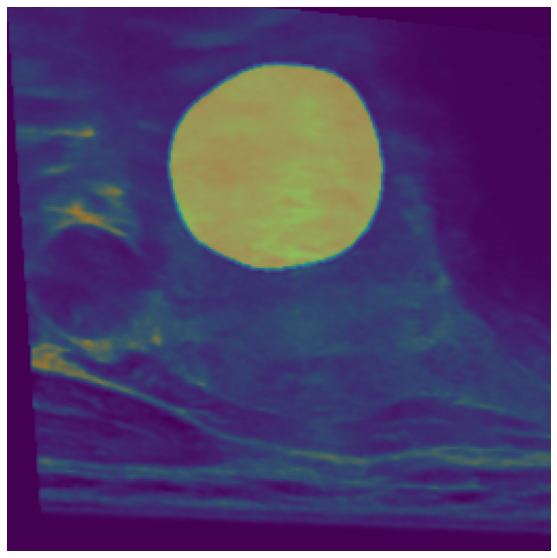

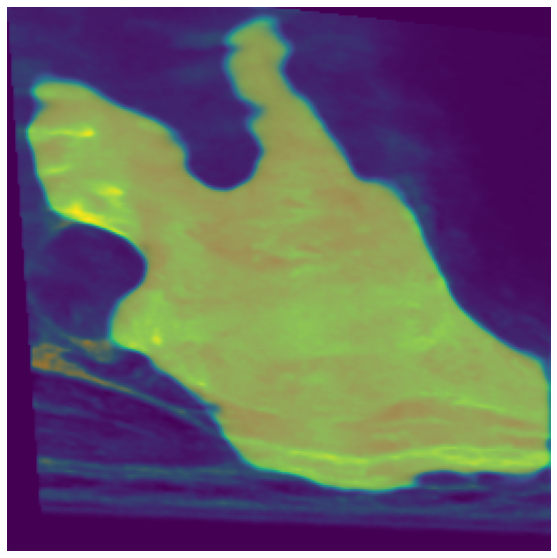

In [36]:
unet_2d_tester = ModelTester('unet_2d/old/2023-04-13-08-45-53/', val_gen)
unet_2d_tester.create_report()

In [6]:
def cutom_focal_tversky(y_true, y_pred, alpha=0.7, gamma=4/3):
    return losses.focal_tversky(y_true, y_pred, alpha=alpha, gamma=gamma)

custom_objects = {'cutom_focal_tversky': cutom_focal_tversky}

In [7]:
# u2_net_tester = ModelTester('u2net_2d/old/2023-04-13-07-48-28/', val_gen, custom_objects)

In [8]:
# u2_net_tester.plot_history()

In [9]:
# u2_net_tester.make_prediction()

In [10]:
def plot_history(history):
    # Extract the history values
    loss = history['loss']
    acc = history['accuracy']
    val_loss = history['val_loss']
    val_acc = history['val_accuracy']

    # Plot the loss values
    plt.figure(figsize=(16, 8))
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # Plot the accuracy values
    plt.figure(figsize=(16, 8))
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.show()

## Load Model

In [11]:
def create_report(path, model_summary=False, custom_objects=None):
    base_path = f'output/{path}'
    model_path = f'{base_path}model/model'
    meta_path = f'{base_path}meta/'
    history = json.load(open(meta_path+'history.json'))
    plot_history(history)
    custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    
    
    # output_masks = model.predict(np.expand_dims(images, 3))
    # cm = confusion_matrix(flat_truth, flat_preds(masks, output_masks))
    # print(cm)
    
    output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(output_mask, alpha=0.5)
    plt.axis('off')
    plt.show()
    
    if model_summary:
        print(model.summary())

In [12]:
custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}

### Classic U-Net

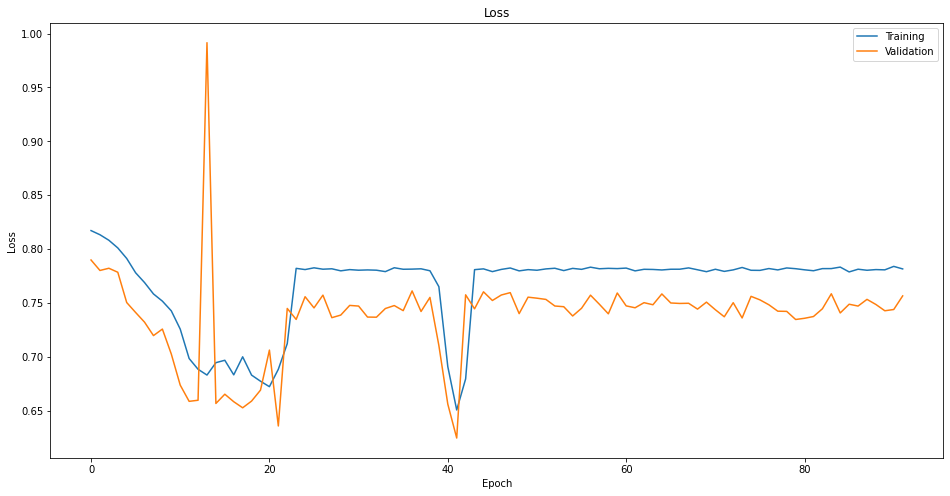

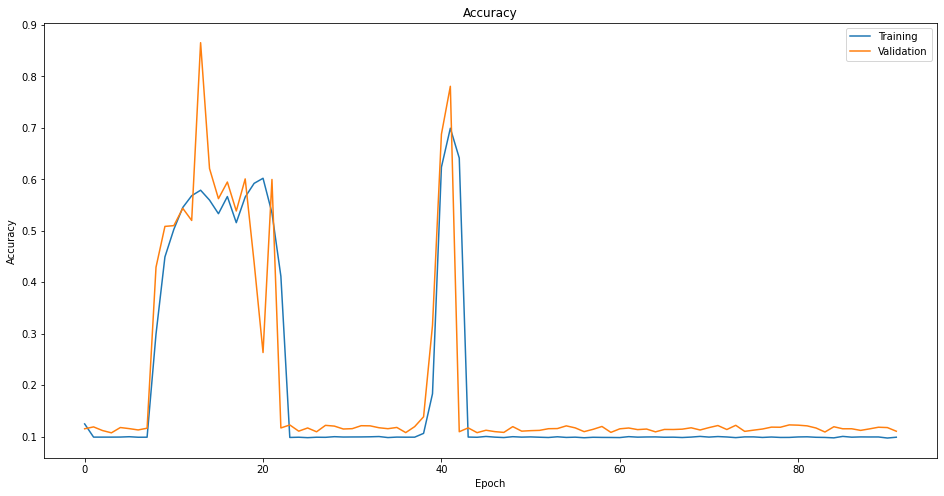

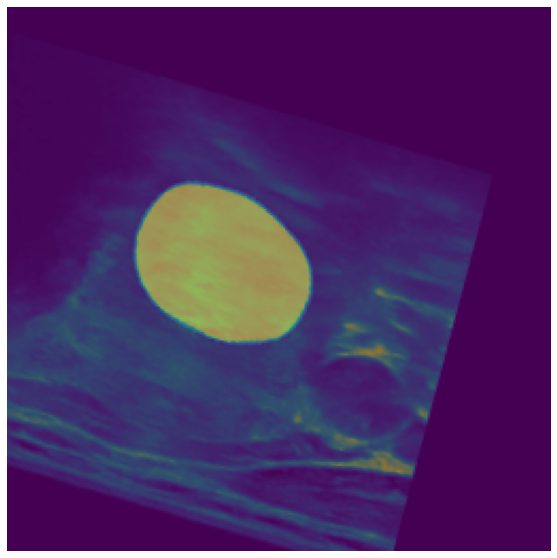

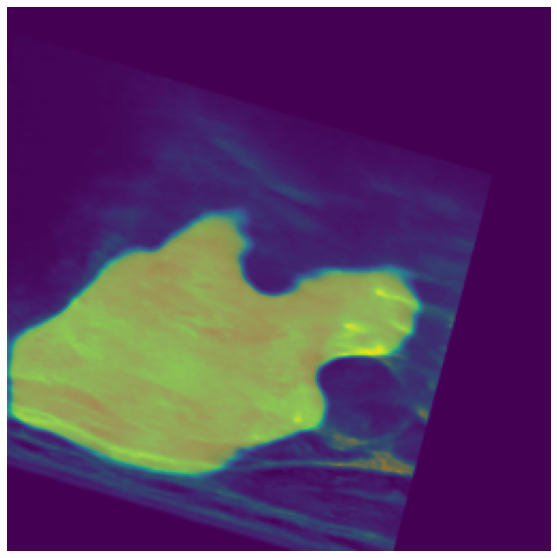

In [13]:
create_report('unet_2d/old/2023-04-13-08-45-53/')

### U^2-Net

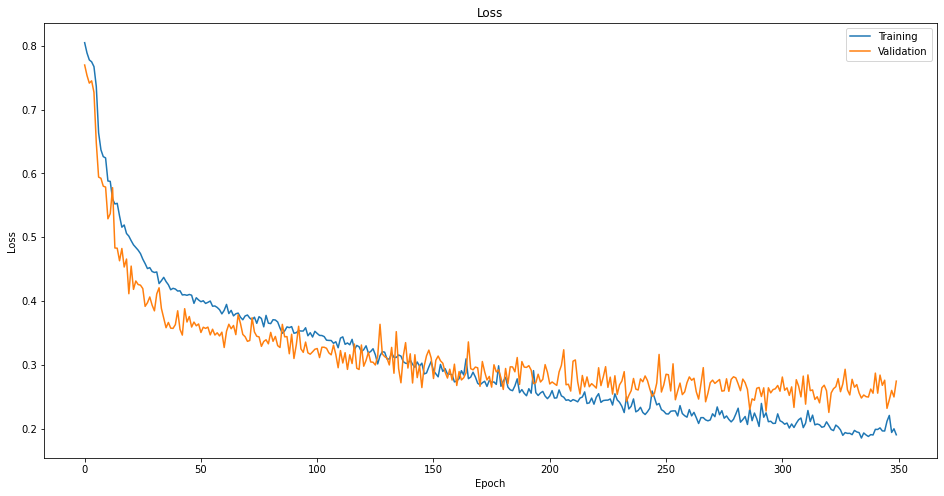

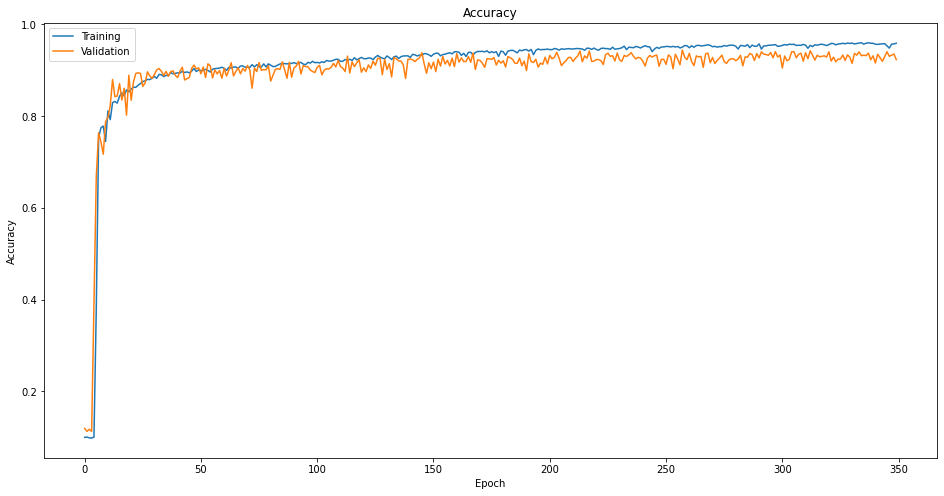

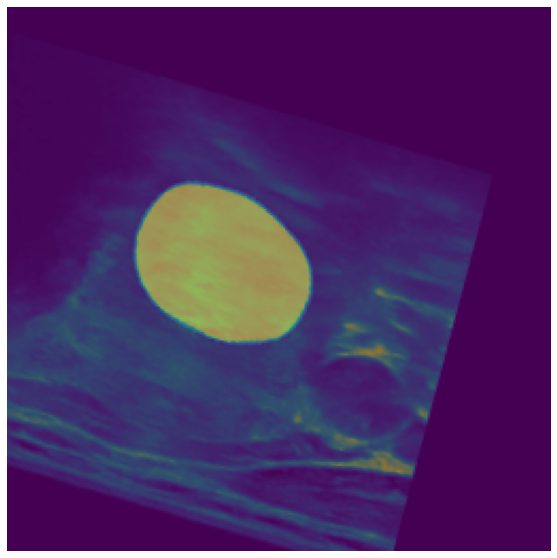

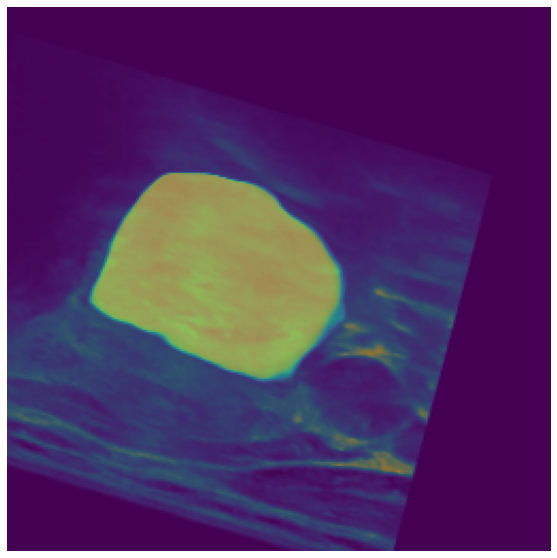

In [14]:
custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
create_report('u2net_2d/old/2023-04-13-07-48-28/', custom_objects=custom_objects)

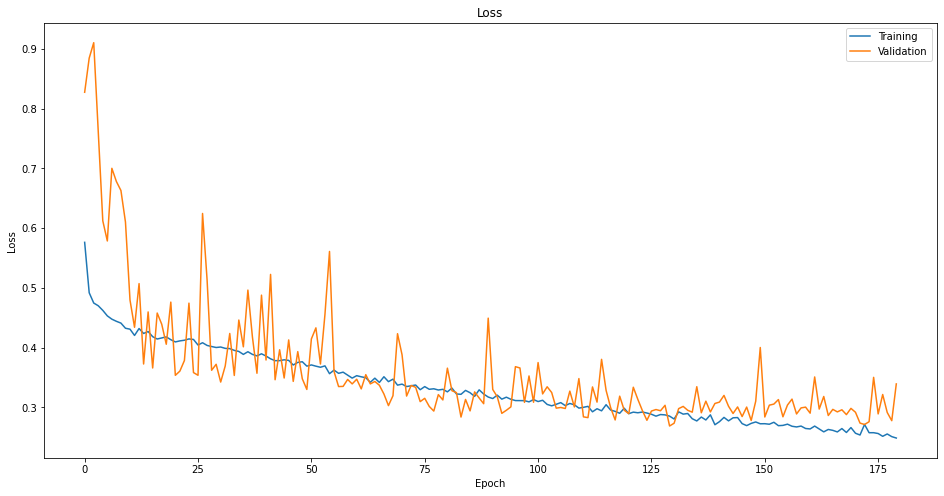

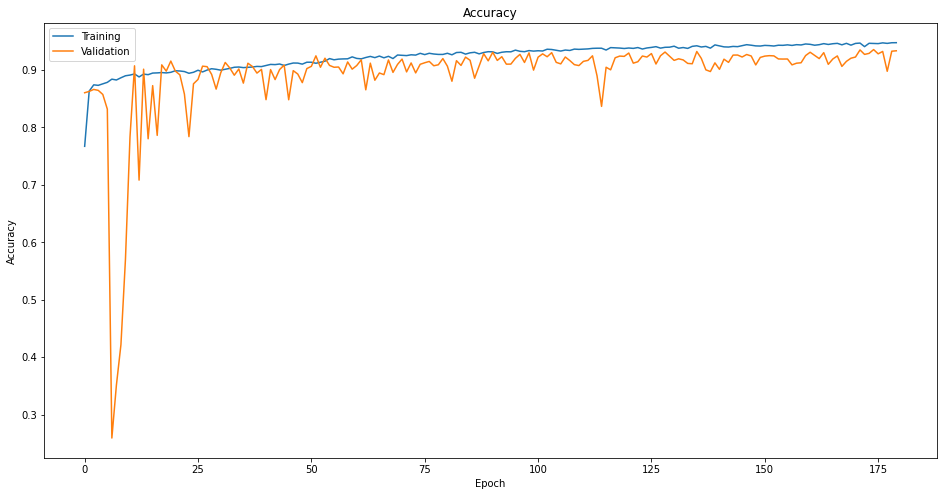

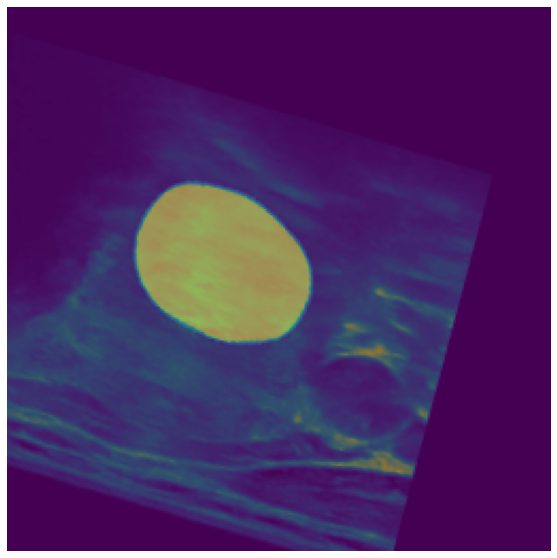

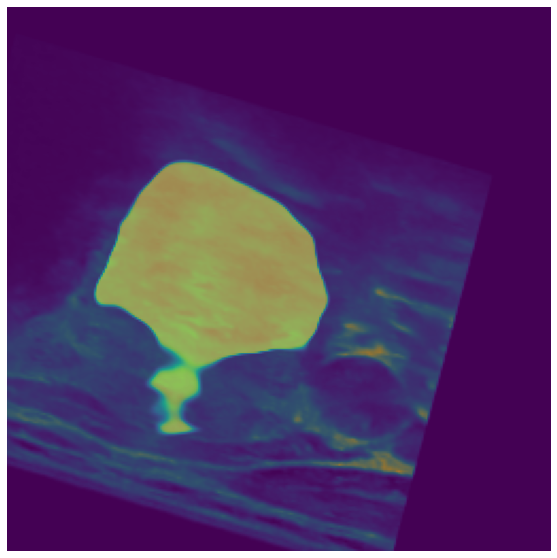

In [15]:
custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
create_report('unet_3plus_2d/old/2023-04-12-20-51-00/', custom_objects=custom_objects)
# # create_report('unet_3plus_2d/2023-04-13-07-48-28/', custom_objects)

In [16]:
# custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
# create_report('unet_3plus_2d/old/2023-04-12-20-51-00/', custom_objects)
# # create_report('unet_3plus_2d/2023-04-13-07-48-28/', custom_objects)

In [17]:
# train_gen = UltraSoundImages(batch_size, train_images, train_masks, size=(512,512))
# val_gen = UltraSoundImages(batch_size, validation_images, validation_masks, size=(512,512))
# test_gen = UltraSoundImages(batch_size, test_images, test_masks, size=(512,512))

In [18]:
# images, masks = val_gen.__getitem__(5)
# image = images[0]
# mask = masks[0]

In [19]:
# np.max(masks)

In [20]:
# np.min(output_masks.flatten())

In [21]:
# cm = confusion_matrix(np.round(masks.flatten()), np.round(output_masks.flatten()), labels=[0,1])
# print(cm)

In [22]:
# cm

In [23]:
# base_path='output/u2net_2d/old/2023-04-13-07-48-28/'
# model_path = f'{base_path}model/model'
# # meta_path = f'{base_path}meta/'
# # history = json.load(open(meta_path+'history.json'))
# # plot_history(history)
# # model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
# model_path = f'{base_path}model/model'
# meta_path = f'{base_path}meta/'
# history = json.load(open(meta_path+'history.json'))
# plot_history(history)
# custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
# model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# # output_masks = model.predict(np.expand_dims(images, 3))
# # cm = confusion_matrix(flat_truth, flat_preds(masks, output_masks))
# # print(cm)

In [24]:
# output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]

In [25]:
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.imshow(mask, alpha=0.5)
# plt.axis('off')
# plt.show()
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.imshow(output_mask, alpha=0.5)
# plt.axis('off')
# plt.show()

### Model trained on Samunsung DS performance on DS

In [26]:
# output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]

In [27]:
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.imshow(mask, alpha=0.5)
# plt.axis('off')
# plt.show()
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.imshow(output_mask, alpha=0.5)
# plt.axis('off')
# plt.show()

In [28]:
# custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
# # create_report('u2net_2d/2023-04-08-07-58-40/', custom_objects)
# create_report('u2net_2d/2023-04-13-07-48-28/', custom_objects)

### U-Net 3+

In [29]:
# base_path='output/unet_3plus_2d/old/2023-04-12-20-51-00/'
# model_path = f'{base_path}model/model'
# # meta_path = f'{base_path}meta/'
# # history = json.load(open(meta_path+'history.json'))
# # plot_history(history)
# # model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
# model_path = f'{base_path}model/model'
# meta_path = f'{base_path}meta/'
# history = json.load(open(meta_path+'history.json'))
# plot_history(history)
# custom_objects = {"cutom_focal_tversky": cutom_focal_tversky}
# model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

In [30]:
# output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]

In [31]:
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.imshow(mask, alpha=0.5)
# plt.axis('off')
# plt.show()
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.imshow(output_mask, alpha=0.5)
# plt.axis('off')
# plt.show()

In [32]:
# output_mask = model.predict(np.expand_dims(image, axis=[0,3]))[0]

In [33]:
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.imshow(mask, alpha=0.5)
# plt.axis('off')
# plt.show()
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# # plt.imshow(output_mask, alpha=0.5)
# plt.axis('off')
# plt.show()

### Trans U-Net

### Swin U-Net